In [1]:
import json
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import traceback


from transformer_lens import HookedTransformer
from utils.utils_MI import load_jsonl

# auto reload
%load_ext autoreload
%autoreload 2

/mnt/miniconda3/envs/r2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_grad_enabled(False)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# 1. Collect Contextual Object Comparison (COC) Question and Model Responses

## 1.1 Preproess COC Questions

In [5]:
sample_qa_pairs_fp = r"3_contextual_object_comparision_qa_pairs.csv"

try:
	df_qa = pd.read_csv(sample_qa_pairs_fp, encoding='utf-8')
except UnicodeDecodeError:
	try:
		df_qa = pd.read_csv(sample_qa_pairs_fp, encoding='latin1')  # This often works for files with Windows encoding
	except:
		df_qa = pd.read_csv(sample_qa_pairs_fp, encoding='cp1252')  # Windows default encoding

df_qa = df_qa.reset_index(drop=True)	
df_qa['case_id'] = df_qa.index

df_qa['answers'] = df_qa['query_a'].apply(lambda x: [e.strip() for e in x[:-1].split(":")[-1].split(" or ")])
assert all(len(answer_list) == 2 for answer_list in df_qa['answers']), "Each question should have exactly 2 answers"

print(f"df_qa.shape: {df_qa.shape}")
df_qa.head(2)

df_qa.shape: (197, 8)


,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers
0,"Considering ocean by area, which is larger: Pa...",Pacific,"Considering ocean by coastline, which is large...",Atlantic,Geography,"Pacific has the greatest surface area, while t...",0,"[Pacific, Atlantic]"
1,"Considering the result of 2+2, which is correc...",4,"Considering the result of 2+3, which is correc...",5,Mathematics,2?+?2 equals?4; 2?+?3 equals?5.,1,"[4, 5]"


In [6]:
model_llama_8B = HookedTransformer.from_pretrained_no_processing(
    r"deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    dtype=torch.bfloat16,
    device=device,
)
model_qwen_1p5B = HookedTransformer.from_pretrained_no_processing(
    r"deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    dtype=torch.bfloat16,
    device=device,
)
model_qwen_7B = HookedTransformer.from_pretrained_no_processing(
    r"deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    dtype=torch.bfloat16,
    device=device,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Llama-8B into HookedTransformer


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-7B into HookedTransformer


In [7]:
df_qa['llama-8B_answer_a_tok_len'] = df_qa['answer_a'].apply(lambda x: len(model_llama_8B.to_str_tokens(x, prepend_bos=False)))
df_qa['llama-8B_answer_b_tok_len'] = df_qa['answer_b'].apply(lambda x: len(model_llama_8B.to_str_tokens(x, prepend_bos=False)))
df_qa['qwen-1p5B_answer_a_tok_len'] = df_qa['answer_a'].apply(lambda x: len(model_qwen_1p5B.to_str_tokens(x, prepend_bos=False)))
df_qa['qwen-1p5B_answer_b_tok_len'] = df_qa['answer_b'].apply(lambda x: len(model_qwen_1p5B.to_str_tokens(x, prepend_bos=False)))
df_qa['qwen-7B_answer_a_tok_len'] = df_qa['answer_a'].apply(lambda x: len(model_qwen_7B.to_str_tokens(x, prepend_bos=False)))
df_qa['qwen-7B_answer_b_tok_len'] = df_qa['answer_b'].apply(lambda x: len(model_qwen_7B.to_str_tokens(x, prepend_bos=False)))

df_qa.tail(2)

,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers,llama-8B_answer_a_tok_len,llama-8B_answer_b_tok_len,qwen-1p5B_answer_a_tok_len,qwen-1p5B_answer_b_tok_len,qwen-7B_answer_a_tok_len,qwen-7B_answer_b_tok_len
195,"Considering gem red, which is: ruby or topaz?",ruby,"Considering gem yellow, which is: ruby or topaz?",topaz,gemology,Ruby is red; yellow varieties of topaz are com...,195,"[ruby, topaz]",1,2,1,2,1,2
196,"Considering pet purr, which is: cat or dog?",cat,"Considering pet bark, which is: cat or dog?",dog,pets,Cats purr; dogs bark.,196,"[cat, dog]",1,1,1,1,1,1


In [8]:
df_qa_sel = df_qa[
    (df_qa['llama-8B_answer_a_tok_len'] == 1) & (df_qa['llama-8B_answer_b_tok_len'] == 1) &
    (df_qa['qwen-1p5B_answer_a_tok_len'] == 1) & (df_qa['qwen-1p5B_answer_b_tok_len'] == 1) &
    (df_qa['qwen-7B_answer_a_tok_len'] == 1) & (df_qa['qwen-7B_answer_b_tok_len'] == 1)
].reset_index(drop=True)

df_qa_sel.shape

(103, 14)

In [9]:
# Function to check if a string can be converted to a number
def is_number(s):
    try:
        float(s)
        return 1
    except ValueError:
        return 0

# Apply the function to create a new column indicating if this is a number comparison case
df_qa_sel['is_number_case'] = df_qa_sel['answer_a'].apply(lambda x: is_number(x))
df_qa_sel['is_binary_case'] = df_qa_sel['answer_a'].apply(lambda x: 1 if x in ["yes", "no"] else 0)

df_qa_sel.groupby(['is_number_case', 'is_binary_case']).size().reset_index(name='counts')

,is_number_case,is_binary_case,counts
0,0,0,41
1,0,1,20
2,1,0,42


In [10]:
# Save df_qa_sel as a CSV file
output_filename = '3_selected_qa_pairs.csv'
df_qa_sel.to_csv(output_filename, index=False)
print(f"Successfully saved {len(df_qa_sel)} selected QA pairs to {output_filename}")

,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers,llama-8B_answer_a_tok_len,llama-8B_answer_b_tok_len,qwen-1p5B_answer_a_tok_len,qwen-1p5B_answer_b_tok_len,qwen-7B_answer_a_tok_len,qwen-7B_answer_b_tok_len,is_number_case,is_binary_case
101,"Considering shape three sides, which is: trian...",triangle,"Considering shape four sides, which is: triang...",square,geometry,3?sided shape is triangle; 4?sided is square.,193,"['triangle', 'square']",1,1,1,1,1,1,False,False
102,"Considering pet purr, which is: cat or dog?",cat,"Considering pet bark, which is: cat or dog?",dog,pets,Cats purr; dogs bark.,196,"['cat', 'dog']",1,1,1,1,1,1,False,False


## 1.2 Generate Model Answers to COC Questions

In [5]:
# load
output_filename = '3_selected_qa_pairs.csv'
df_qa_sel = pd.read_csv(output_filename, encoding='utf-8')
df_qa_sel = df_qa_sel.reset_index(drop=True)
df_qa_sel.tail(2)

,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers,llama-8B_answer_a_tok_len,llama-8B_answer_b_tok_len,qwen-1p5B_answer_a_tok_len,qwen-1p5B_answer_b_tok_len,qwen-7B_answer_a_tok_len,qwen-7B_answer_b_tok_len,is_number_case,is_binary_case
101,"Considering shape three sides, which is: trian...",triangle,"Considering shape four sides, which is: triang...",square,geometry,3?sided shape is triangle; 4?sided is square.,193,"['triangle', 'square']",1,1,1,1,1,1,False,False
102,"Considering pet purr, which is: cat or dog?",cat,"Considering pet bark, which is: cat or dog?",dog,pets,Cats purr; dogs bark.,196,"['cat', 'dog']",1,1,1,1,1,1,False,False


In [6]:
# model_alias, model_path = 'llama-8B', r"deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model_alias, model_path = 'qwen-1p5B', r"deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_alias, model_path = 'qwen-7B', r"deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" 

model = HookedTransformer.from_pretrained_no_processing(
    model_path,
    # center_unembed=True,
    # fold_ln=True,
    dtype=torch.bfloat16,
    device=device,
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


In [ ]:
save_fp = f"3_sample_qa_pair_responses.jsonl"
query_suffix = " Please reason step by step (but not overthinking), and put your final answer within \\boxed{}. <think>\n"

# First, load existing entries to avoid duplicates
existing_entries = set()
try:
    with open(save_fp, "r") as f:
        for line in f:
            entry = json.loads(line)
            existing_entries.add(entry["unique_id"])
    print(f"Loaded {len(existing_entries)} existing entries from {save_fp}")
except FileNotFoundError:
    print(f"No existing file found at {save_fp}. Creating new file.")
    # Create the file with an empty write
    with open(save_fp, "w") as f:
        pass
    
for i, row in tqdm(df_qa_sel.iterrows(), total=len(df_qa_sel)):
    # if i > 0:
    #     break
    unique_id = f"{model_alias}_{row['case_id']}"
    
    # Skip if this entry already exists
    if unique_id in existing_entries:
        print(f"Skipping existing entry: {unique_id}")
        continue
        
    response_a = model.generate(row['query_a'] + query_suffix, max_new_tokens=3000, do_sample=False, prepend_bos=True)
    response_b = model.generate(row['query_b'] + query_suffix, max_new_tokens=3000, do_sample=False, prepend_bos=True)
    d_tmp = {
        "unique_id": unique_id,
        "model_alias": model_alias,
        "case_id": row['case_id'],
        "question_a": row['query_a'],
        "response_a": response_a,  
        "question_b": row['query_b'],
        "response_b": response_b,  
        "gt_a": row['answer_a'],
        "gt_b": row['answer_b'],
    }
    
    with open(save_fp, "a") as f:
        f.write(json.dumps(d_tmp) + "\n")
    
    # Add to existing entries set to avoid duplicates within the same run
    existing_entries.add(unique_id)

# 2. Collect Data from Activation Patching

In [5]:
# model_alias, model_path = 'llama-8B', r"deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model_alias, model_path = 'qwen-1p5B', r"deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_alias, model_path = 'qwen-7B', r"deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" 

model = HookedTransformer.from_pretrained_no_processing(
    model_path,
    # center_unembed=True,
    # fold_ln=True,
    dtype=torch.bfloat16,
    device=device,
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer


In [6]:
from QAPairResultProcesser import QAPairResultProcesser

save_fp = f"3_sample_qa_pair_responses.jsonl"
qaprp = QAPairResultProcesser(save_fp=save_fp)

df_sel = qaprp.df.copy()
df_sel = df_sel[df_sel["model_alias"] == model_alias]
df_sel = df_sel[(((df_sel["is_answer_a_correct"] == 1)|(df_sel["has_answer_in_ending_a"] == 1))\
                &((df_sel["is_answer_b_correct"] == 1)|(df_sel["has_answer_in_ending_b"] == 1)))].reset_index(drop=True)
df_sel = df_sel.reset_index(drop=True)

display(df_sel.head(2))

df_sel.shape

,unique_id,model_alias,case_id,question_a,response_a,question_b,response_b,gt_a,gt_b,comparator,...,answer_a,answer_b,answer_a_index_from_end,answer_b_index_from_end,is_answer_a_index_from_end_correct,is_answer_b_index_from_end_correct,is_answer_a_correct,is_answer_b_correct,has_answer_in_ending_a,has_answer_in_ending_b
0,qwen-1p5B_6,qwen-1p5B,6,"Considering symbol for sodium, which is correc...","Considering symbol for sodium, which is correc...","Considering symbol for potassium, which is cor...","Considering symbol for potassium, which is cor...",Na,K,correct,...,Na,K,-4,-3,1,1,1,1,0,0
1,qwen-1p5B_7,qwen-1p5B,7,"Considering atomic number of carbon, which is ...","Considering atomic number of carbon, which is ...","Considering atomic number of nitrogen, which i...","Considering atomic number of nitrogen, which i...",6,7,correct,...,6,7,-5,-3,1,1,1,1,0,0


(22, 21)

df_fine_grain.shape: (716, 24)
# of Existing:  128


  0%|          | 0/22 [00:00<?, ?it/s]

Before padding:


,index,r_start_idx,r_end_idx,tot_answer_tokens,tot_tokens
0,clean,35,363,109,474
1,corrupted,35,466,112,580


After padding:


,index,r_start_idx,r_end_idx,tot_answer_tokens,tot_tokens
0,clean,35,466,112,580
1,corrupted,35,466,112,580


reasoning_backoff: 5
answer_backoff: None
After insert_probe_phrase:


,index,r_start_idx,r_end_idx,tot_answer_tokens,tot_tokens
0,clean,35,42,112,156
1,corrupted,35,42,112,156


l_patching_region: [[37, 42]]
l_patching_special_tokens: [42, 155]
step: 1
Processing region 0: [37, 42]


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


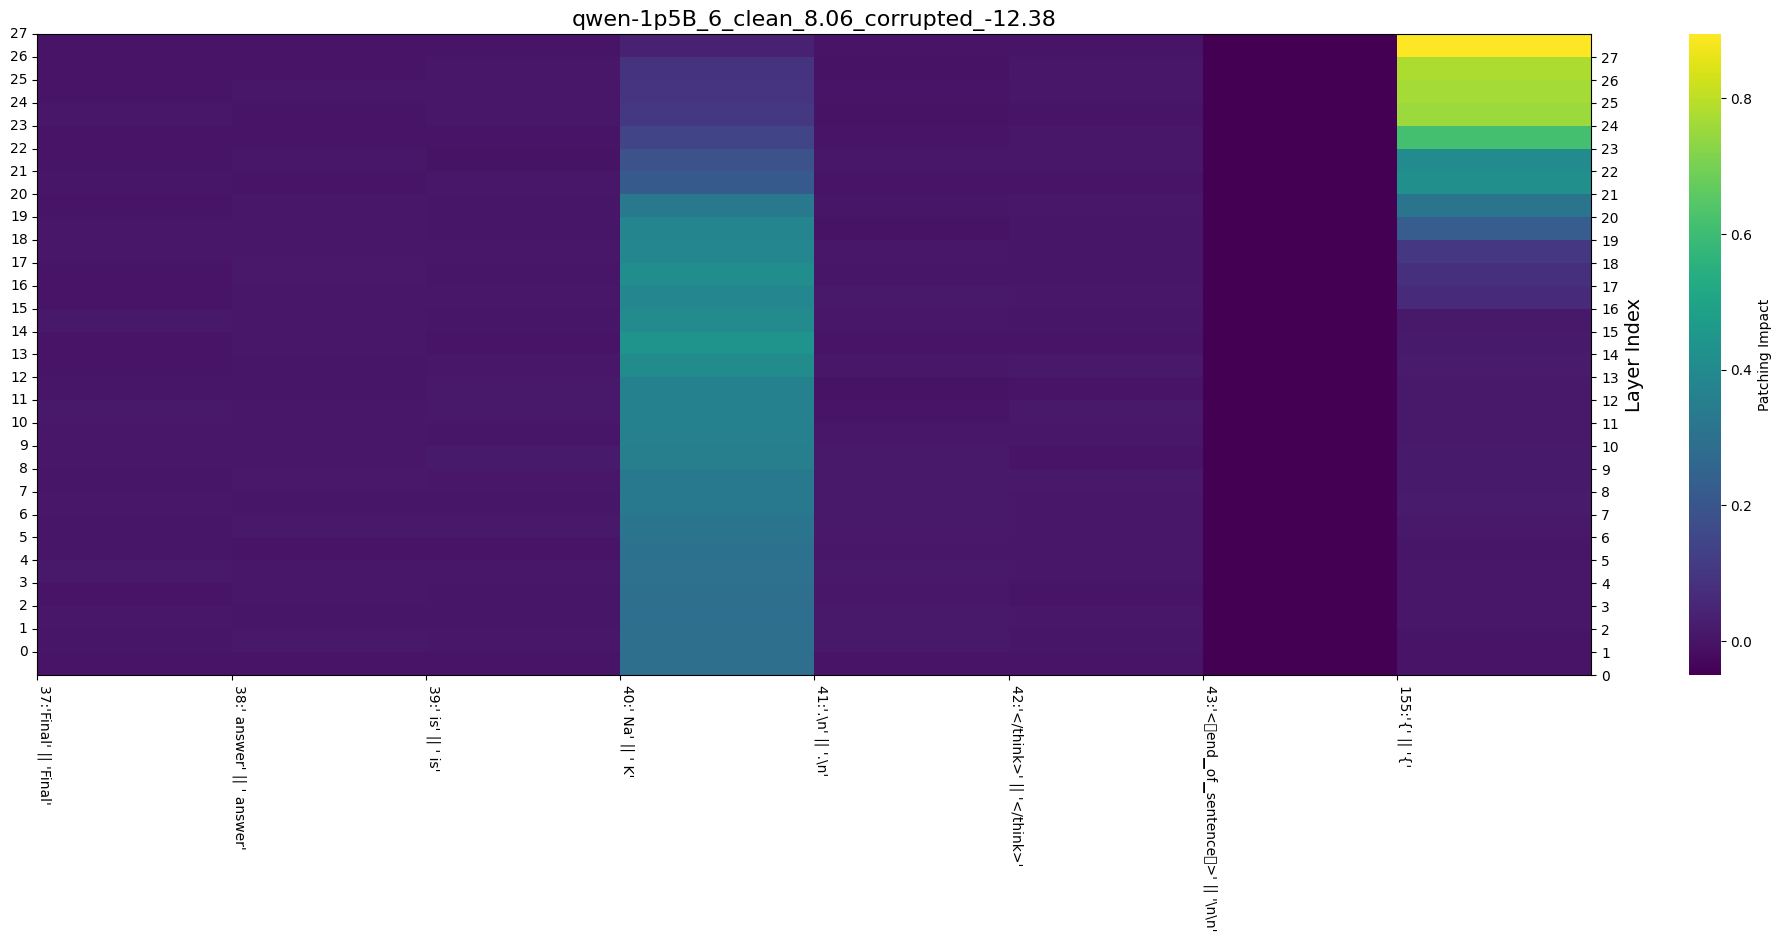

100%|██████████| 22/22 [00:12<00:00,  1.83it/s]


In [18]:
from QAPairPatchingAnalyzer import QAPairPatchingAnalyzer, QAPairResult, plot_fine_grain_res

fine_grain_patching_fp = r"3_fine_grain_patching.jsonl"

# create fine_grain_patching_fp if not exists
if not os.path.exists(fine_grain_patching_fp):
    with open(fine_grain_patching_fp, 'w') as f:
        pass

# probing scenario
# answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = 0, 1, 1, 0, 0, 0
# answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = 0, 0, 1, 0, 0, 0
# answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = 0, 1, 1, 0, 0, 1
# answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = 0, 2, 1, 0, 0, 1
answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = 0, 0, 1, 0, 0, 0

df_fine_grain = pd.DataFrame(load_jsonl(fine_grain_patching_fp))
print(f"df_fine_grain.shape: {df_fine_grain.shape}")

l_existing_scenario_id = []
if df_fine_grain.shape[0] > 0:
    l_existing_scenario_id = df_fine_grain['scenario_id'].unique().tolist()
    l_existing_scenario_id = [e for e in l_existing_scenario_id if e.startswith(f"{model_alias}")]
print('# of Existing: ', len(l_existing_scenario_id))

for i, row in tqdm(df_sel.iterrows(), total=len(df_sel)):
    # if i > 0:
    #     continue
    scenario_id = f"{row['unique_id']}" + "_answer_ending_version_" + str(answer_ending_version) \
                    + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    scenario_id_variant = scenario_id
    if is_include_prior_reasoning:
        scenario_id_variant = f"{row['unique_id']}" + "_answer_ending_version_" + str(answer_ending_version) \
                    + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}"
    
    if scenario_id in l_existing_scenario_id or scenario_id_variant in l_existing_scenario_id:
        print(f"Skipping existing scenario: {scenario_id}, as it already exists in {fine_grain_patching_fp}")
        continue

    try:
        qapr = QAPairResult(
            unique_id=row["unique_id"],
            model_alias=row["model_alias"],
            case_id=row["case_id"],
            question_a=row["question_a"],
            response_a=row["response_a"],
            question_b=row["question_b"],
            response_b=row["response_b"],
            comparator=row["comparator"],
            gt_a=row["gt_a"],
            gt_b=row["gt_b"],
            str_answers=row["str_answers"],
            answer_a=row["answer_a"],
            answer_b=row["answer_b"],
            answer_a_index_from_end=row["answer_a_index_from_end"],
            answer_b_index_from_end=row["answer_b_index_from_end"]
        )

        qappa = QAPairPatchingAnalyzer(
            qapr, 
            model=model,
            fine_grain_patching_fp=fine_grain_patching_fp,
            answer_ending_version = answer_ending_version,
            probe_phrase_version = probe_phrase_version,
            is_probe_reasoning = is_probe_reasoning,
            is_probe_answer = is_probe_answer,
            is_probe_query = is_probe_query,
            is_include_prior_reasoning = is_include_prior_reasoning,
            is_debug=True,
            is_save=False
            )
        qappa.pre_processing()

        qappa.align_answer_ending_format()
        qappa.trim_reasoning_ending_format()
        qappa.padding()
        qappa.insert_probe_phrase()
        # qappa.quick_check()

        qappa.get_clean_cache()
        qappa.get_corrupted_cache()
        qappa.hook_fine_grain_resid_auto()
        plot_fine_grain_res(qappa.hook_fine_grain_results, qappa=qappa)
    except Exception as e:
        print(f"Error processing row {i} for id {row['unique_id']}: {e}")
        print(traceback.format_exc())
        continue

# 3. Reproduce Plots in the Paper

## 3.1  Figure 7: Normalized Logit Difference for a Sample Case (Layer-Wise Heatmap)

In [19]:
from QAPairPatchingAnalyzer import QAPairPatchingAnalyzer, QAPairResult, plot_fine_grain_res
from QAPairResultProcesser import QAPairResultProcesser

In [ ]:
paper_figure_folder_path = r"output/paper_figures"

QA_pair_fp = '3_selected_qa_pairs.csv'
QA_pair_response_fp = f"3_sample_qa_pair_responses.jsonl"
fine_grain_patching_fp = r"3_fine_grain_patching.jsonl"

In [21]:
from const import D_MODEL_ALIAS_PATH, D_MODEL_ALIAS_LABEL_MAPPING

l_scenario = [
    [0, 0, 1, 0, 0, 1], # answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning
    [0, 1, 1, 0, 0, 1], 
    [0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0], 
]

l_model_alias = ['llama-8B', 'qwen-7B', 'qwen-1p5B']

d_model_path = D_MODEL_ALIAS_PATH

d_model_alias_name = D_MODEL_ALIAS_LABEL_MAPPING

In [22]:
df_qa_sel = pd.read_csv(QA_pair_fp, encoding='utf-8')
df_qa_sel = df_qa_sel.reset_index(drop=True)
df_qa_sel.tail(2)

,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers,llama-8B_answer_a_tok_len,llama-8B_answer_b_tok_len,qwen-1p5B_answer_a_tok_len,qwen-1p5B_answer_b_tok_len,qwen-7B_answer_a_tok_len,qwen-7B_answer_b_tok_len,is_number_case,is_binary_case
101,"Considering shape three sides, which is: trian...",triangle,"Considering shape four sides, which is: triang...",square,geometry,3?sided shape is triangle; 4?sided is square.,193,"['triangle', 'square']",1,1,1,1,1,1,False,False
102,"Considering pet purr, which is: cat or dog?",cat,"Considering pet bark, which is: cat or dog?",dog,pets,Cats purr; dogs bark.,196,"['cat', 'dog']",1,1,1,1,1,1,False,False


In [23]:
df_fine_grain = pd.DataFrame(load_jsonl(fine_grain_patching_fp))
df_fine_grain = df_fine_grain.reset_index(drop=True)
df_fine_grain.head(2)

,scenario_id,model_alias,case_id,answer_ending_version,answer_ending,is_probe_reasoning,is_probe_answer,is_probe_query,probe_version,clean_probe_phrase,...,clean_r_start_idx,clean_r_end_idx,corrupted_r_start_idx,corrupted_r_end_idx,reasoning_backoff,answer_backoff,clean_average_logit_diff,corrupted_average_logit_diff,hook_fine_grain_results,hook_fine_grain_results_metrics
0,llama-8B_6_answer_ending_version_0_probe_phras...,llama-8B,6,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is Na.\n,...,35,1284,35,1284,6.0,NaN,7.125,-9.7500,"{'region_1278_1279': [0.0, 0.0, -0.00741577148...","{'region_1278_1279': {'0': {'logits': [17.0, 2..."
1,qwen-1p5B_6_answer_ending_version_0_probe_phra...,qwen-1p5B,6,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is Na.\n,...,35,471,35,471,5.0,NaN,6.500,-11.1875,"{'region_466_467': [0.0, 0.007080078125, 0.0, ...","{'region_466_467': {'0': {'logits': [14.8125, ..."


In [24]:
answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = l_scenario[0]
scenario_label = "answer_ending_version_" + str(answer_ending_version) \
                    + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
scenario_label_variant = "answer_ending_version_" + str(answer_ending_version) \
                    + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}"

# df_scenario = df_fine_grain[df_fine_grain['scenario_id'].str.endswith(scenario_label)]
df_scenario = df_fine_grain[df_fine_grain['scenario_id'].str.endswith(scenario_label_variant)]
df_scenario = df_scenario[(df_scenario['clean_average_logit_diff'] > 5.)&(df_scenario['corrupted_average_logit_diff'] < -5.)] # selection criteria

df_scenario.shape

(43, 24)

In [25]:
df_scenario.groupby(['case_id']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)

,case_id,count
4,24,3
29,193,3
2,7,2
5,40,2
7,51,2


In [26]:
# case_id = 193
case_id = 24
df_scenario_sel = df_scenario[df_scenario['case_id'] == case_id]
df_scenario_sel

,scenario_id,model_alias,case_id,answer_ending_version,answer_ending,is_probe_reasoning,is_probe_answer,is_probe_query,probe_version,clean_probe_phrase,...,clean_r_start_idx,clean_r_end_idx,corrupted_r_start_idx,corrupted_r_end_idx,reasoning_backoff,answer_backoff,clean_average_logit_diff,corrupted_average_logit_diff,hook_fine_grain_results,hook_fine_grain_results_metrics
5,qwen-1p5B_24_answer_ending_version_0_probe_phr...,qwen-1p5B,24,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is 5.\n,...,38,886,38,886,6.0,NaN,5.125,-5.75,"{'region_880_881': [0.0, 0.0, 0.0, -0.01147460...","{'region_880_881': {'0': {'logits': [20.125, 2..."
12,qwen-7B_24_answer_ending_version_0_probe_phras...,qwen-7B,24,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is 5.\n,...,38,1325,38,1325,6.0,NaN,10.250,-10.25,"{'region_1319_1320': [0.0, 0.006103515625, 0.0...","{'region_1319_1320': {'0': {'logits': [19.625,..."
17,llama-8B_24_answer_ending_version_0_probe_phra...,llama-8B,24,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is 5.\n,...,38,1965,38,1965,7.0,NaN,8.750,-7.75,"{'region_1958_1959': [0.0, 0.0, 0.0, 0.0, 0.0,...","{'region_1958_1959': {'0': {'logits': [16.5, 2..."


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Llama-8B into HookedTransformer
Processing region 0: [1958, 1965]


100%|██████████| 7/7 [01:55<00:00, 16.46s/it]


Processing region 1: [2134, 2136]


100%|██████████| 2/2 [00:33<00:00, 16.68s/it]
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


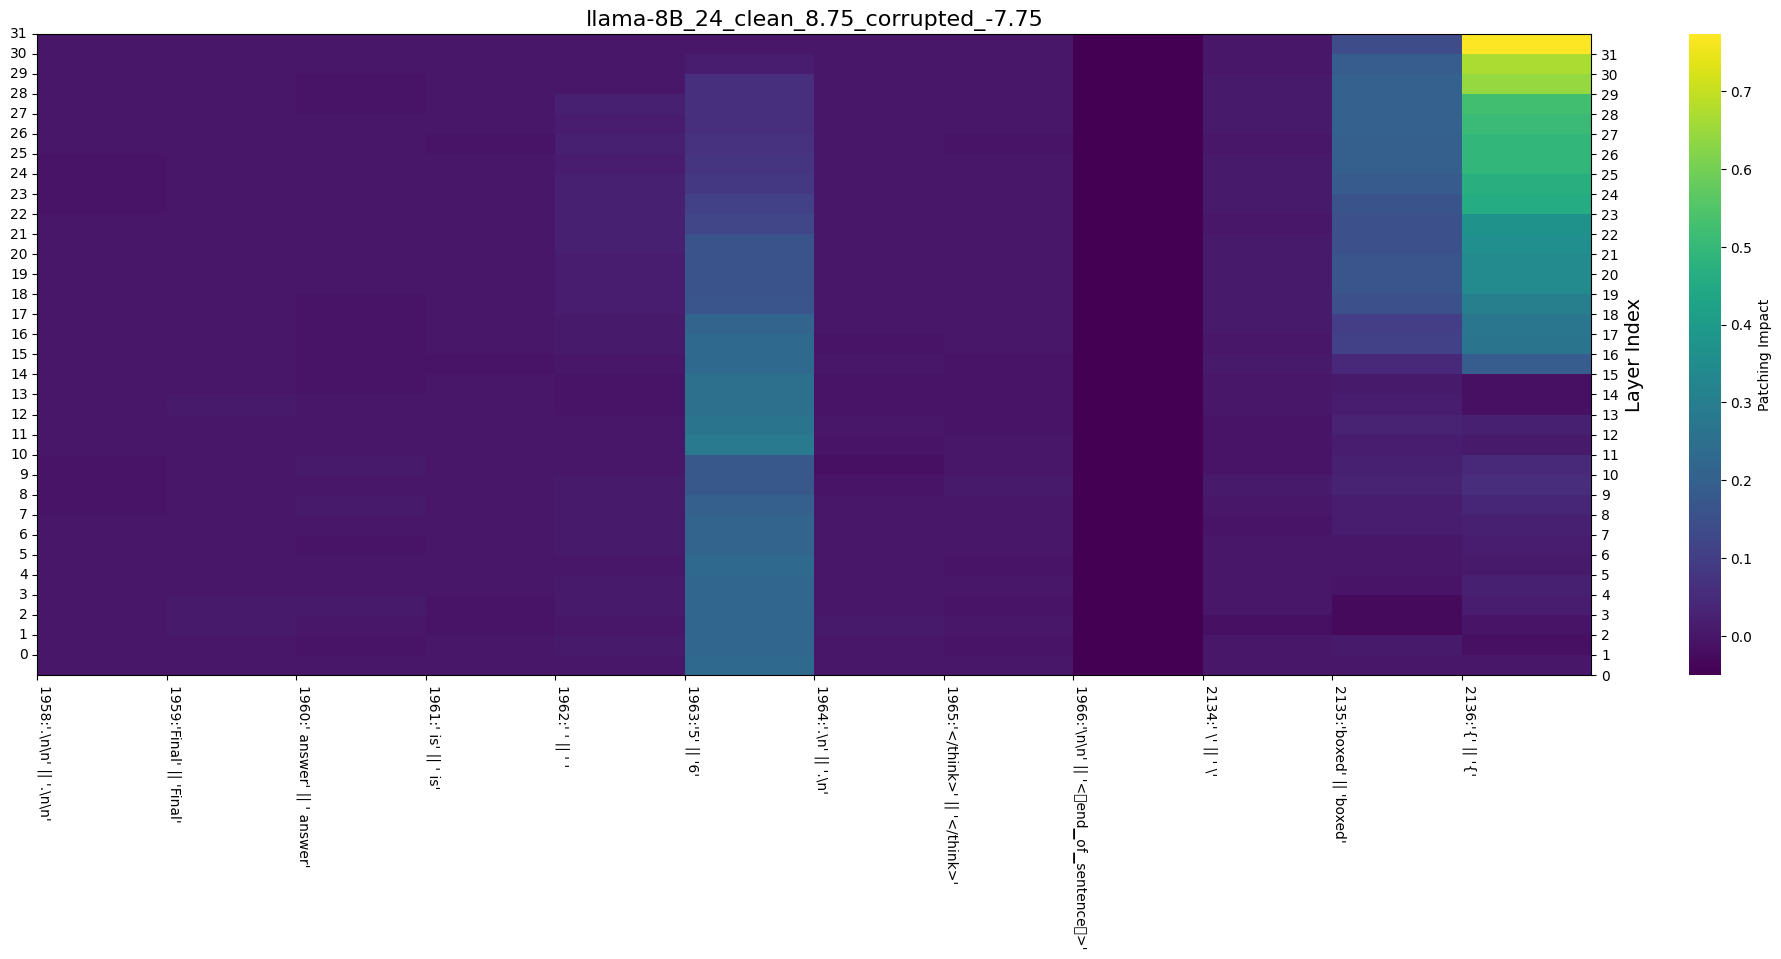

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-7B into HookedTransformer
Processing region 0: [1319, 1325]


100%|██████████| 6/6 [00:46<00:00,  7.79s/it]


Processing region 1: [1520, 1522]


100%|██████████| 2/2 [00:15<00:00,  7.83s/it]
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


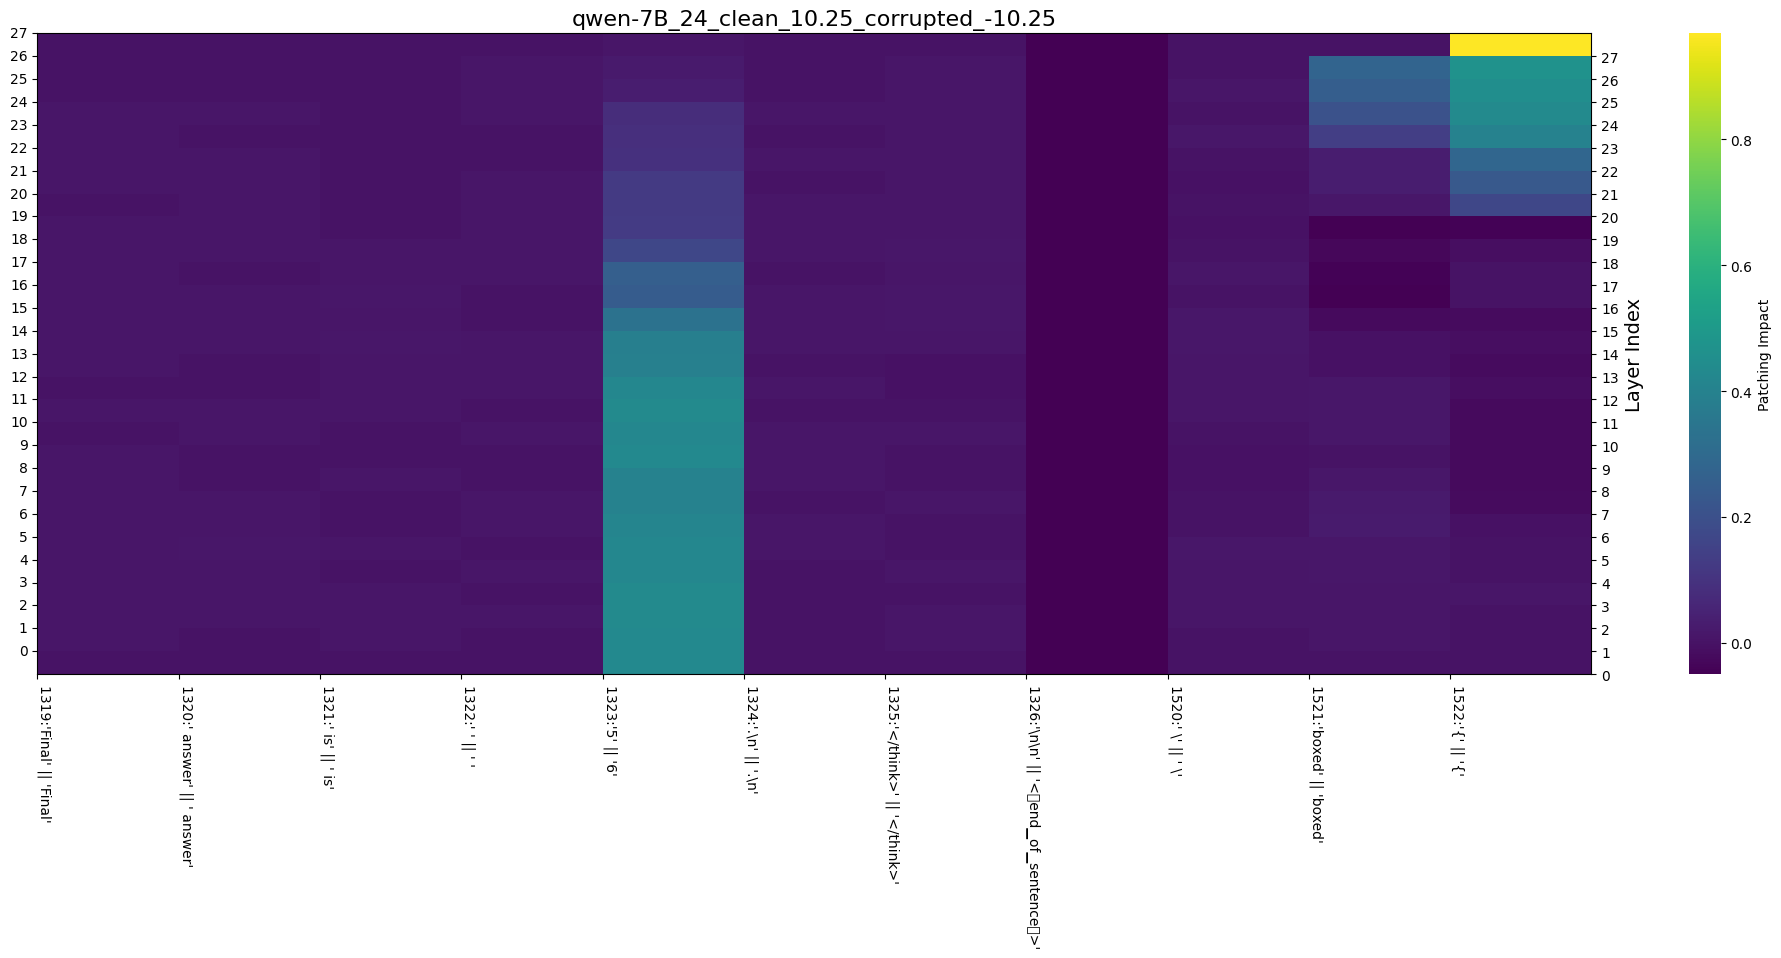

Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer
Processing region 0: [880, 886]


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Processing region 1: [1012, 1014]


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


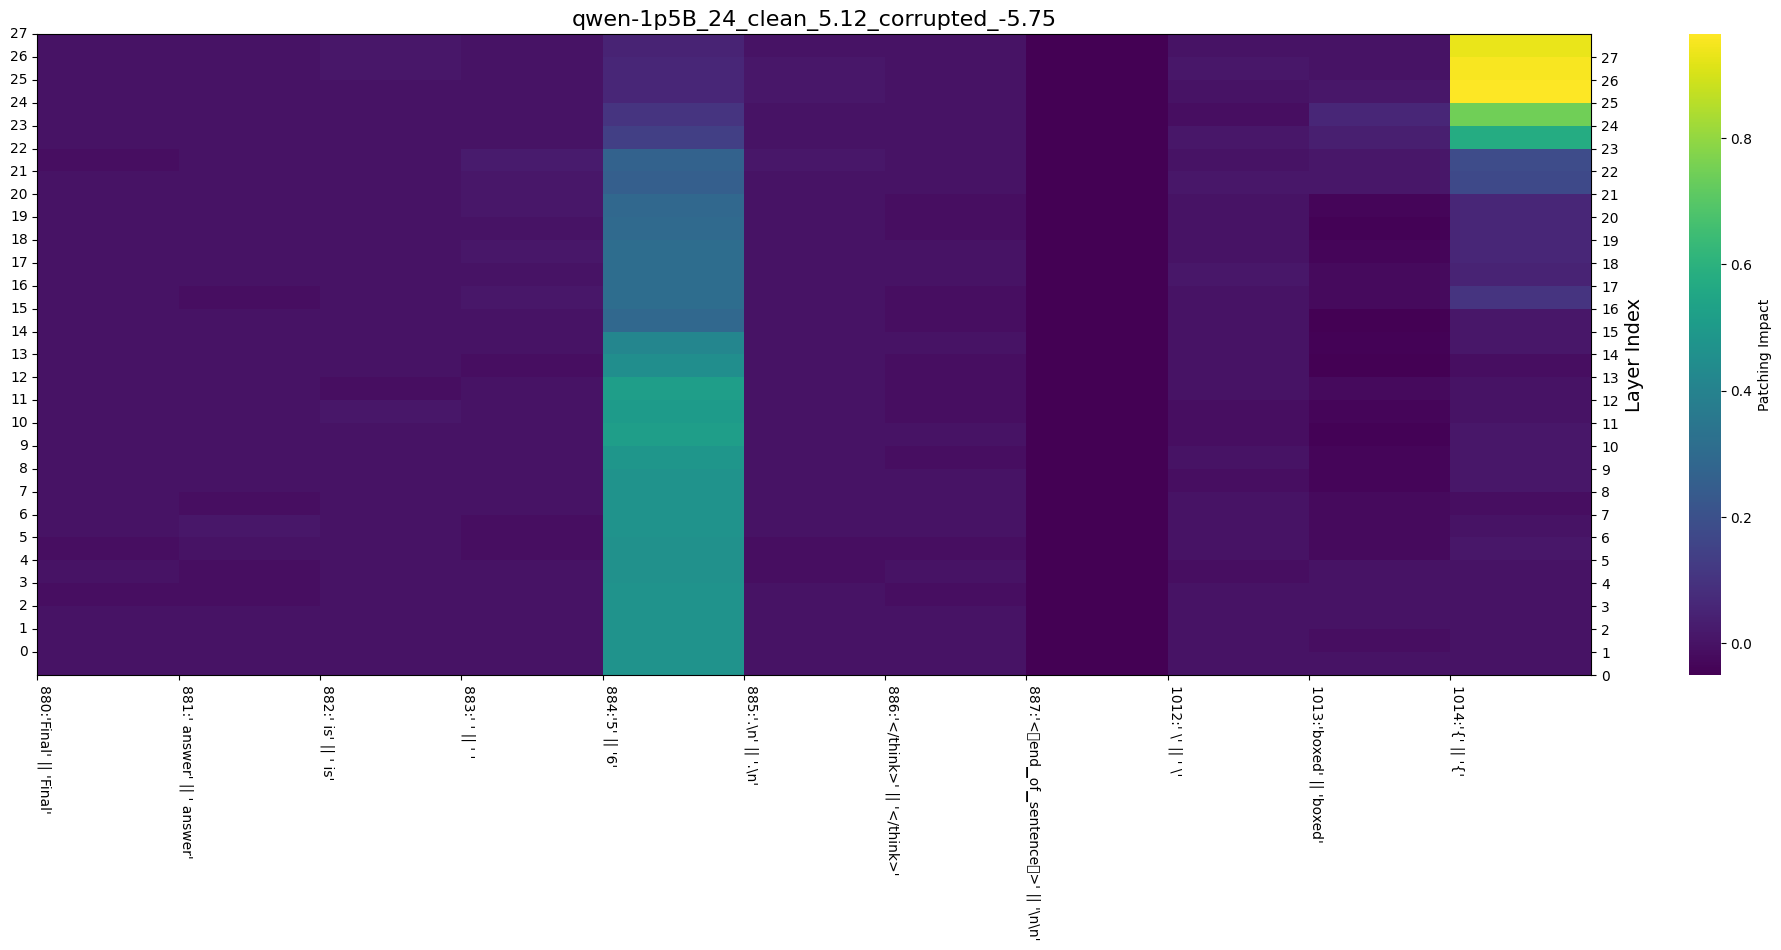

In [27]:
d_res = {}
for model_alias in l_model_alias:
    
    model = HookedTransformer.from_pretrained_no_processing(
        d_model_path[model_alias],
        # center_unembed=True,
        # fold_ln=True,
        dtype=torch.bfloat16,
        device=device,
    )

    qaprp = QAPairResultProcesser(save_fp=QA_pair_response_fp)

    df_sel = qaprp.df.copy()
    df_sel = df_sel[df_sel["model_alias"] == model_alias]
    # df_sel = df_sel[(df_sel["is_answer_a_correct"] == 1)&(df_sel["is_answer_b_correct"] == 1)].reset_index(drop=True)
    df_sel = df_sel[(((df_sel["is_answer_a_correct"] == 1)|(df_sel["has_answer_in_ending_a"] == 1))\
                    &((df_sel["is_answer_b_correct"] == 1)|(df_sel["has_answer_in_ending_b"] == 1)))].reset_index(drop=True)

    row = df_sel[df_sel['case_id'] == case_id].iloc[0]

    qapr = QAPairResult(
        unique_id=row["unique_id"],
        model_alias=row["model_alias"],
        case_id=row["case_id"],
        question_a=row["question_a"],
        response_a=row["response_a"],
        question_b=row["question_b"],
        response_b=row["response_b"],
        comparator=row["comparator"],
        gt_a=row["gt_a"],
        gt_b=row["gt_b"],
        str_answers=row["str_answers"],
        answer_a=row["answer_a"],
        answer_b=row["answer_b"],
        answer_a_index_from_end=row["answer_a_index_from_end"],
        answer_b_index_from_end=row["answer_b_index_from_end"]
    )

    qappa = QAPairPatchingAnalyzer(
        qapr, 
        model=model,
        answer_ending_version = answer_ending_version,
        probe_phrase_version = probe_phrase_version,
        is_probe_reasoning = is_probe_reasoning,
        is_probe_answer = is_probe_answer,
        is_probe_query = is_probe_query,
        is_include_prior_reasoning = is_include_prior_reasoning,
        # is_debug=True,
        is_save=False
        )

    qappa.pre_processing()

    qappa.align_answer_ending_format()
    qappa.trim_reasoning_ending_format()
    qappa.padding()
    qappa.insert_probe_phrase()
    # qappa.quick_check()

    qappa.get_clean_cache()
    qappa.get_corrupted_cache()
    qappa.hook_fine_grain_resid_auto(answer_backoff=3)

    d_res[model_alias] = {
        'fine_grain_results': qappa.hook_fine_grain_results,
        'clean_str_tokens': qappa.clean_str_tokens,
        'corrupted_str_tokens': qappa.corrupted_str_tokens,
    }
    plot_fine_grain_res(qappa.hook_fine_grain_results, qappa=qappa)

In [ ]:
import pickle

with open(os.path.join(f"3_activation_patching_case_{case_id}.pkl"), "wb") as f:
    pickle.dump(d_res, f)

In [31]:
import pickle
case_id = 24
with open(os.path.join(f"3_activation_patching_case_{case_id}.pkl"), "rb") as f:
    d_patching_res = pickle.load(f)
d_patching_res.keys()

dict_keys(['llama-8B', 'qwen-7B', 'qwen-1p5B'])

/tmp/ipykernel_3068461/2461554396.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


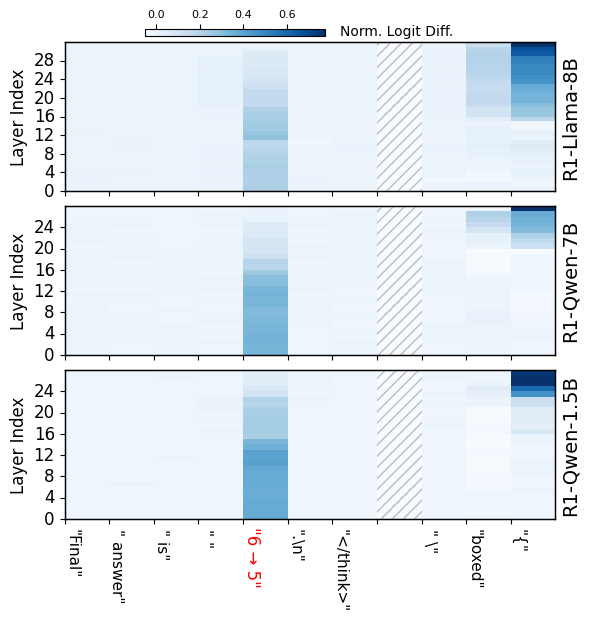

In [32]:
from collections import OrderedDict

d_model_alias_label_mapping = {
    'llama-8B': 'R1-Llama-8B',
    'qwen-7B': 'R1-Qwen-7B',
    'qwen-1p5B': 'R1-Qwen-1.5B'
}

# Create a figure with 3 rows, 1 column (3 plots)
fig, axes = plt.subplots(3, 1, figsize=(6, 6.5), sharex=True)
plt.rcParams["text.usetex"] = False

for i, model_alias in enumerate(l_model_alias):
    d_tmp = d_patching_res[model_alias]
    d_plot = d_tmp['fine_grain_results']
    clean_str_tokens = d_tmp['clean_str_tokens']
    corrupted_str_tokens = d_tmp['corrupted_str_tokens']

    if model_alias == 'llama-8B':
        d_plot.pop('region_1958_1959', None)  # None as default value prevents KeyError if key doesn't exist
    
    # Process the d_res dictionary - sort keys by start position
    def get_sort_key(key):
        parts = key.split('_')
        # Handle both formats: "region_start_end" and "special_token_start_end"
        if parts[0] == 'special':
            return int(parts[2])  # Use the position for special tokens
        else:
            return int(parts[1])  # Use start position for regions

    # Create a complete version of d_res that includes gap regions
    complete_d_res = {}

    # First, add all existing entries
    for key, value in d_plot.items():
        complete_d_res[key] = value

    # Extract positions and identify gaps
    positions = []
    end_positions = []
    for key in d_plot.keys():
        parts = key.split('_')
        if parts[0] == 'special':
            pos = int(parts[2])
            positions.append(pos)
            end_positions.append(pos + 1)  # Special tokens are just one position
        else:
            start = int(parts[1])
            end = int(parts[2])
            positions.append(start)
            end_positions.append(end)

    # Sort the positions
    positions = sorted(set(positions))
    end_positions = sorted(set(end_positions))

    # Create a default tensor with the same length as the values in d_res
    first_value = next(iter(d_plot.values()))
    default_tensor = [-100] * len(first_value)  # Create a list of -100s with the same length

    # Fill in gaps between regions
    all_positions = sorted(set(positions + end_positions))
    for j in range(len(all_positions) - 1):
        start = all_positions[j]
        end = all_positions[j + 1]
        
        # Check if this range is already covered
        key = f"region_{start}_{end}"
        special_key = f"special_token_{start}_{end}"
        
        is_covered = False
        for existing_key in d_plot.keys():
            parts = existing_key.split('_')
            if parts[0] == 'region':
                existing_start = int(parts[1])
                existing_end = int(parts[2])
                if start >= existing_start and end <= existing_end:
                    is_covered = True
                    break
            elif parts[0] == 'special' and int(parts[2]) == start and int(parts[2]) + 1 >= end:
                is_covered = True
                break
        
        # If the range isn't covered, add it with default tensor
        if not is_covered and start != end:
            if end - start == 1 and any(p == start for p in positions):
                # This might be a special token position
                complete_d_res[f"special_token_{start}_{end}"] = default_tensor
            else:
                complete_d_res[f"region_{start}_{end}"] = default_tensor

    # Now sort all keys
    sorted_keys = sorted(complete_d_res.keys(), key=get_sort_key)
    sorted_d_res = OrderedDict([(k, complete_d_res[k]) for k in sorted_keys])

    # Extract positions from the sorted keys
    positions = []
    labels = []
    for key in sorted_keys:
        parts = key.split('_')
        if parts[0] == 'special':
            position = int(parts[2])
        else:
            position = (int(parts[1]))
        positions.append(position)

    # Stack the arrays from sorted_d_res into a 2D matrix
    l_arrays = [e for e in sorted_d_res.values()]
    data_matrix = np.vstack(l_arrays).T[::-1,:]  # Transpose and reverse rows

    # Create x-tick labels with positions
    x_ticks = np.arange(len(sorted_keys))
    
    if len(labels) == len(sorted_keys):
        x_labels = labels
    else:
        x_labels = [str(pos) for pos in positions]
    x_labels = ['"Final"', '" answer"', '" is"', '" "', 
                '', 
                '".\\n"', '"</think>"', '', '" \\"', '"boxed"', '"{"']
                
    # Determine value range for colormap
    vmin = max(-0.05, np.min(data_matrix))
    vmax = min(1.0, np.max(data_matrix))

    # Create heatmap with gap regions included
    ax = sns.heatmap(data_matrix, cmap="Blues", vmin=vmin, vmax=vmax, 
                    xticklabels=x_labels, cbar=False, ax=axes[i])

    # Set x-ticks and labels
    ax.set_xticklabels([])
    if i == 2:
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=-90, ha='left', fontsize=11)
        ax.text(
            4 + 0.2,
            -0.05,  # below the plot
            '"6 → 5"',
            color='red',
            ha='center',
            va='top',
            fontsize=12,
            rotation=-90,
            transform=ax.get_xaxis_transform()
        )

    # Y-labels are layer indices (reversed)
    # Show only every 4th tick
    step = 4
    y_labels = [f"{i}" for i in range(data_matrix.shape[0]) if i % step == 0][::-1]
    y_ticks = np.arange(len(y_labels))
    ax.set_yticks(np.arange(0, data_matrix.shape[0], step)+4) 
    ax.set_yticklabels(y_labels, rotation=0, fontsize=12)   

    # Create a second y-axis for the model name
    ax2 = ax.twinx()
    ax2.set_ylabel(d_model_alias_label_mapping[model_alias], fontsize=14)
    ax2.set_yticks([])  # Hide the ticks of the secondary y-axis
    
    # Highlight hatched area between "</think>" and " \\"
    start_token = '"</think>"'
    end_token = '" \\"'

    # Find the x positions of the start and end tokens
    try:
        start_idx = x_labels.index(start_token)
        end_idx = x_labels.index(end_token)
        
        # Draw a hatched rectangle over that span
        ax.axvspan(start_idx+1, end_idx, facecolor='none', edgecolor='grey', hatch='///', linewidth=0.0, zorder=10, alpha=0.5)
    except ValueError:
        print(f"Could not find token positions for hatched area in model {model_alias}")

    # Set title and labels
    # ax.set_title(d_model_alias_name[model_alias], fontsize=14)
    ax.set_ylabel('Layer Index', fontsize=12)

    # add boarder to the heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')

# Create a colorbar at the top of the first plot
cbar_ax = fig.add_axes([0.25, 0.91, 0.3, 0.01])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_ticks_position('top')
plt.text(1.1, 0.6, "Norm. Logit Diff.", ha='center', va='center', fontsize=10)
# cbar.set_label('Norm. Logit Diff')
# cbar.ax.xaxis.set_label_position('top')

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.1)

save_fg_path = os.path.join(paper_figure_folder_path, f'activation_patching_case_heatmap.png')
if not os.path.exists(os.path.dirname(save_fg_path)):
    os.makedirs(os.path.dirname(save_fg_path))
plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# save as pdf
save_fg_path_pdf = os.path.join(paper_figure_folder_path, f'activation_patching_case_heatmap.pdf')
plt.savefig(save_fg_path_pdf, dpi=300, bbox_inches='tight')

plt.show()


## 3.2 Figure 8: Normalized Logit Difference for All Cases 

In [33]:
paper_figure_folder_path = r"paper_figures"

QA_pair_fp = '3_selected_qa_pairs.csv'
QA_pair_response_fp = f"3_sample_qa_pair_responses.jsonl"
fine_grain_patching_fp = r"3_fine_grain_patching.jsonl"

In [34]:
l_scenario = [
    [0, 0, 1, 0, 0, 1], # answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning
    [0, 1, 1, 0, 0, 1], 
    [0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0], 
]

l_model_alias = ['llama-8B', 'qwen-7B', 'qwen-1p5B']

In [35]:
df_qa_sel = pd.read_csv(QA_pair_fp, encoding='utf-8')
df_qa_sel = df_qa_sel.reset_index(drop=True)
df_qa_sel.tail(2)

,query_a,answer_a,query_b,answer_b,domain,explanation,case_id,answers,llama-8B_answer_a_tok_len,llama-8B_answer_b_tok_len,qwen-1p5B_answer_a_tok_len,qwen-1p5B_answer_b_tok_len,qwen-7B_answer_a_tok_len,qwen-7B_answer_b_tok_len,is_number_case,is_binary_case
101,"Considering shape three sides, which is: trian...",triangle,"Considering shape four sides, which is: triang...",square,geometry,3?sided shape is triangle; 4?sided is square.,193,"['triangle', 'square']",1,1,1,1,1,1,False,False
102,"Considering pet purr, which is: cat or dog?",cat,"Considering pet bark, which is: cat or dog?",dog,pets,Cats purr; dogs bark.,196,"['cat', 'dog']",1,1,1,1,1,1,False,False


In [36]:
df_fine_grain = pd.DataFrame(load_jsonl(fine_grain_patching_fp))
df_fine_grain = df_fine_grain.reset_index(drop=True)
df_fine_grain.head(2)

,scenario_id,model_alias,case_id,answer_ending_version,answer_ending,is_probe_reasoning,is_probe_answer,is_probe_query,probe_version,clean_probe_phrase,...,clean_r_start_idx,clean_r_end_idx,corrupted_r_start_idx,corrupted_r_end_idx,reasoning_backoff,answer_backoff,clean_average_logit_diff,corrupted_average_logit_diff,hook_fine_grain_results,hook_fine_grain_results_metrics
0,llama-8B_6_answer_ending_version_0_probe_phras...,llama-8B,6,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is Na.\n,...,35,1284,35,1284,6.0,NaN,7.125,-9.7500,"{'region_1278_1279': [0.0, 0.0, -0.00741577148...","{'region_1278_1279': {'0': {'logits': [17.0, 2..."
1,qwen-1p5B_6_answer_ending_version_0_probe_phra...,qwen-1p5B,6,0,"Thus, the correct one is \boxed{",1,0,0,0,Final answer is Na.\n,...,35,471,35,471,5.0,NaN,6.500,-11.1875,"{'region_466_467': [0.0, 0.007080078125, 0.0, ...","{'region_466_467': {'0': {'logits': [14.8125, ..."


In [37]:
d_res_for_plot = {}

for model_alias in l_model_alias:
    df_fine_grain_model = df_fine_grain[df_fine_grain['model_alias'] == model_alias]

    d_model = {}
    for scenario in l_scenario:
        answer_ending_version, probe_phrase_version, is_probe_reasoning, is_probe_answer, is_probe_query, is_include_prior_reasoning = scenario
        scenario_label = "answer_ending_version_" + str(answer_ending_version) \
                            + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
        scenario_label_variant = "answer_ending_version_" + str(answer_ending_version) \
                            + "_probe_phrase_version_" + str(probe_phrase_version) + f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}"

        df_scenario = df_fine_grain_model[df_fine_grain_model['scenario_id'].str.endswith(scenario_label)]
        if len(df_scenario) == 0:
            df_scenario = df_fine_grain_model[df_fine_grain_model['scenario_id'].str.endswith(scenario_label_variant)]
        assert len(df_scenario) > 0, f"no data for {model_alias} in {scenario_label}"

        df_scenario = df_scenario.sort_values(by=['case_id']).reset_index(drop=True)
        df_scenario = pd.merge(df_scenario, df_qa_sel[['case_id', 'is_number_case', 'is_binary_case']], how='left', on='case_id')

        # df_scenario = df_scenario[(df_scenario['clean_average_logit_diff'] > 5.)&(df_scenario['corrupted_average_logit_diff'] < -5.)] # selection criteria
        print(f"len(df_scenario) = {len(df_scenario)}")

        # collect fine-grain results
        R_PROB_BACKOFF, A_PROB_BACKOFF = 2, 10
        l_r_prob_logit, l_a_prob_logit, l_pred_logit = [], [], []
        for i, row in df_scenario.iterrows():
            try:
                d_res = row['hook_fine_grain_results']

                l_special_token_idx = sorted([int(e.split('_')[-2]) for e in d_res.keys() if e.startswith('special_token_')])
                l_probe_token_idx = sorted([int(e.split('_')[-2]) for e in d_res.keys() if e.startswith('region_')])
                # print(l_special_token_idx, l_probe_token_idx)

                eot_idx, pred_idx = l_special_token_idx
                r_prob_idx, a_prob_idx = eot_idx - R_PROB_BACKOFF, pred_idx - A_PROB_BACKOFF
                # print(r_prob_idx, a_prob_idx)
                
                if is_probe_reasoning:
                    l_r_prob_logit.append(d_res[f"region_{r_prob_idx}_{r_prob_idx+1}"])
                if is_probe_answer:
                    l_a_prob_logit.append(d_res[f"region_{a_prob_idx}_{a_prob_idx+1}"])
                l_pred_logit.append(d_res[f"special_token_{pred_idx}_{pred_idx+1}"])
            except Exception as e:
                print(e)
                print(row['case_id'])
                continue

        l_r_prob_logit = np.array(l_r_prob_logit)
        l_a_prob_logit = np.array(l_a_prob_logit)
        l_pred_logit = np.array(l_pred_logit)

        mean_r_prob = np.mean(l_r_prob_logit, axis=0)
        mean_a_prob = np.mean(l_a_prob_logit, axis=0) 
        mean_pred = np.mean(l_pred_logit, axis=0)
        stderr_r_prob = np.std(l_r_prob_logit, axis=0) 
        stderr_a_prob = np.std(l_a_prob_logit, axis=0) 
        stderr_pred = np.std(l_pred_logit, axis=0) 

        d_scenario = {
            'mean_r_prob': mean_r_prob,
            'mean_a_prob': mean_a_prob,
            'mean_pred': mean_pred,
            'stderr_r_prob': stderr_r_prob,
            'stderr_a_prob': stderr_a_prob,
            'stderr_pred': stderr_pred,
        }
        d_model[scenario_label] = d_scenario

    d_res_for_plot[model_alias] = d_model
        

len(df_scenario) = 25
len(df_scenario) = 56
len(df_scenario) = 39
len(df_scenario) = 21
len(df_scenario) = 14
len(df_scenario) = 65
len(df_scenario) = 50
len(df_scenario) = 31
len(df_scenario) = 10
len(df_scenario) = 22
len(df_scenario) = 20
len(df_scenario) = 22


/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/mnt/miniconda3/envs/sae_reasoning/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/miniconda3/envs/sae_reasoning/

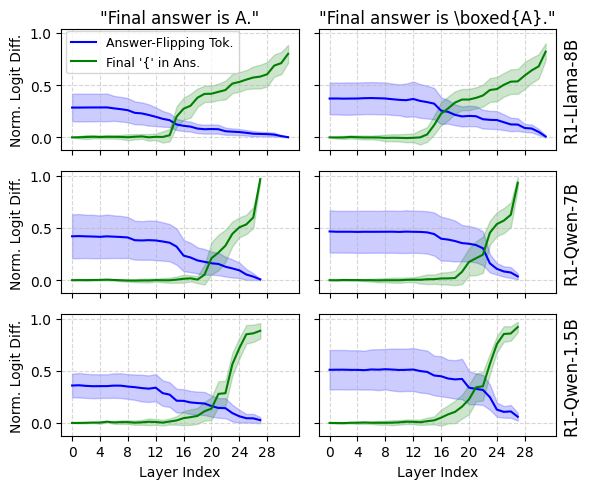

: 

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(6, 5), sharex=True, sharey=True)

d_prob_line_color = {
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_1': 'blue', # f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_0': 'blue',
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_1': 'blue', 
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_0': 'blue', 
}
d_prob_line_style = {
    # 'answer_ending_version_0_probe_phrase_version_0__0_1_0_1': 'dashed', # f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    # 'answer_ending_version_0_probe_phrase_version_1__0_1_0_0': 'solid',
    # 'answer_ending_version_0_probe_phrase_version_1__0_1_0_1': 'solid', 
    # 'answer_ending_version_0_probe_phrase_version_0__0_1_0_0': 'dashed', 
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_1': 'solid', # f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_0': 'dashed',
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_1': 'solid', 
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_0': 'dashed', 
}

d_ax_col = {
    # 'answer_ending_version_0_probe_phrase_version_0__0_1_0_1': 0, # f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    # 'answer_ending_version_0_probe_phrase_version_1__0_1_0_0': 1,
    # 'answer_ending_version_0_probe_phrase_version_1__0_1_0_1': 0, 
    # 'answer_ending_version_0_probe_phrase_version_0__0_1_0_0': 1, 
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_1': 0, # f"__{is_probe_query}_{is_probe_reasoning}_{is_probe_answer}_{is_include_prior_reasoning}"
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_0': 1,
    'answer_ending_version_0_probe_phrase_version_1__0_1_0_1': 1, 
    'answer_ending_version_0_probe_phrase_version_0__0_1_0_0': 0, 
}

d_model_label = {
    'llama-8B': 'R1-Llama-8B',
    'qwen-7B': 'R1-Qwen-7B',
    'qwen-1p5B': 'R1-Qwen-1.5B',
}


for i, model_alias in enumerate(l_model_alias):
    d_model = d_res_for_plot[model_alias]
    for scenario, d_scenario in d_model.items():
        if scenario not in ['answer_ending_version_0_probe_phrase_version_0__0_1_0_1', 'answer_ending_version_0_probe_phrase_version_1__0_1_0_1']:
            continue

        j = d_ax_col[scenario]

        mean_r_prob = d_scenario['mean_r_prob']
        mean_a_prob = d_scenario['mean_a_prob']
        mean_pred = d_scenario['mean_pred']
        stderr_r_prob = d_scenario['stderr_r_prob']
        stderr_a_prob = d_scenario['stderr_a_prob']
        stderr_pred = d_scenario['stderr_pred']

        x = np.arange(len(mean_r_prob))
        # axes[i][j].plot(x, mean_r_prob, label=f"Patch Reasoning", color=d_prob_line_color[scenario], linestyle=d_prob_line_style[scenario])
        # axes[i][j].plot(x, mean_pred, label=f"Patch Answer", color='green', linestyle=d_prob_line_style[scenario])
        axes[i][j].plot(x, mean_r_prob, label=f"Answer-Flipping Tok.", color=d_prob_line_color[scenario], linestyle=d_prob_line_style[scenario])
        axes[i][j].plot(x, mean_pred, label=f"Final '{{' in Ans.", color='green', linestyle=d_prob_line_style[scenario])

        # if scenario in ['answer_ending_version_0_probe_phrase_version_1__0_1_0_0', 'answer_ending_version_0_probe_phrase_version_1__0_1_0_1']:
        if scenario in ['answer_ending_version_0_probe_phrase_version_0__0_1_0_1', 'answer_ending_version_0_probe_phrase_version_1__0_1_0_1']:
            axes[i][j].fill_between(x, mean_r_prob - stderr_r_prob, mean_r_prob + stderr_r_prob, 
                            color='blue', alpha=0.2)
            axes[i][j].fill_between(x, mean_pred - stderr_pred, mean_pred + stderr_pred, 
                            color='green', alpha=0.2)
            
        if j== 0:            
            axes[i][0].set_ylabel('Norm. Logit Diff.', fontsize=10)

        if j == 1:
            axes[i][j].set_ylabel(d_model_label[model_alias], fontsize=12)
            axes[i][j].yaxis.set_label_position("right")

        if i == 2:
            axes[2][j].set_xlabel('Layer Index', fontsize=10)

for ax in axes.flatten():
    ax.grid(True, alpha=0.5, linestyle='--')
    ax.set_xticks(np.arange(0, 32, 4))

axes[0][1].set_xlabel('"Final answer is \\boxed{A}."', fontsize=12)
axes[0][0].xaxis.set_label_position("top")
axes[0][0].set_xlabel('"Final answer is A."', fontsize=12)
axes[0][1].xaxis.set_label_position("top")

axes[0][0].legend(loc='upper left', fontsize=9, bbox_to_anchor=(0.02, 0.98), borderaxespad=0.)

plt.tight_layout()

save_fg_path = os.path.join(paper_figure_folder_path, f'patch_resid_pre.png')
if not os.path.exists(os.path.dirname(save_fg_path)):
    os.makedirs(os.path.dirname(save_fg_path))
plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# save as pdf
save_fg_path_pdf = os.path.join(paper_figure_folder_path, f'patch_resid_pre.pdf')
plt.savefig(save_fg_path_pdf, dpi=300, bbox_inches='tight')

plt.show()